# Making the first prediction in the Forex Market 


![deep_network_model](../images/deep_network_model_avatar.jpg)


The progress of the model can be saved during and after training. This means that a model can be resumed where it left off and avoid long training times. Saving also means that you can share your model and others can recreate your work.

We will illustrate how to create a multiple fully connected hidden layer NN, save it and make predictions with trained model after reload it.

We will use the EURUSD data for this exercise.

We will build a four-hidden layer neural network  to predict the next close price, from the other four features of the precedent period (open, high, low and close).

This is a practical exercise to learn how to make predictions with TensorFlow, but it is a naive approach to the real forecasting problem. Don't worry we will be climbing toward better approaches. Also, in the meantime, you will be able to elaborate on your own systems.

## Load configuration

Below, it  is an example of .env file for your customization:
~~~~
PROJ_DIR=.
DATA_DIR=../data/
RAW_DIR=../data/raw/
INTERIM_DIR=../data/interim/
PROCESSED_DIR=../data/processed/
FIGURES_DIR=../reports/figures/
MODEL_DIR=../models/
EXTERNAL_DIR=../data/external/
PRODUCTION_DIR=/home/PRODUCTION/
~~~~

In [1]:
## 1. Import libraries and modules. Load env variables
import os
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import zipfile
import sqlite3
from datetime import date, datetime, timezone
from dotenv import find_dotenv, load_dotenv

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model.utils import build_tensor_info

from sklearn.preprocessing import MinMaxScaler
#from IPython.display import Image

#Reads the key,value pair from .env and adds them to environment variable 
load_dotenv(find_dotenv())

# Check the env variables exist. Check as many variables as you need
raw_msg = "Set your raw data absolute path in the .env file at project root"
assert "RAW_DIR" in os.environ, raw_msg
data_msg = "Set your processed data absolute path in the .env file at project root"
assert "DATA_DIR" in os.environ, data_msg
interim_msg = "Set your interim data absolute path in the .env file at project root"
assert "INTERIM_DIR" in os.environ, interim_msg

# Load env variables
proj_dir = os.path.expanduser(os.environ.get("PROJ_DIR"))
data_dir = os.path.expanduser(os.environ.get("DATA_DIR"))
raw_dir = os.path.expanduser(os.environ.get("RAW_DIR"))
interim_dir = os.path.expanduser(os.environ.get("INTERIM_DIR"))
processed_dir = os.path.expanduser(os.environ.get("PROCESSED_DIR"))
figures_dir = os.path.expanduser(os.environ.get("FIGURES_DIR"))
model_dir = os.path.expanduser(os.environ.get("MODEL_DIR"))
external_dir = os.path.expanduser(os.environ.get("EXTERNAL_DIR"))
production_dir = os.path.expanduser(os.environ.get("PRODUCTION_DIR"))

# Import our project modules
#
#Add src/app to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/app"))

#Add src/data to the PATH
sys.path.append(os.path.join(proj_dir,"src/data"))
#Ram import make_dataset as md

#Add src/visualization to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/visualization"))
#Ram import visualize as vs

#Data files
#raw_data = 
#interim_data = 

#Global configuration variables
# Send models to production env. folder (True: send. False: Do not send)
to_production = True

/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibili

## Ingest raw data

### Download raw datasets


The great people at [HistData.com](http://www.histdata.com/) have setup the infrastructure necessary to provide you FOREX data for free. This is awesome and if possible, you should donate or purchase some of their services to help them. There exist several tools contained in the internet to download the data, but all of them need your carefully atention. For example:
* https://github.com/philipperemy/FX-1-Minute-Data
* https://github.com/xeb/forex-histdata-etl
* https://gist.github.com/EvianZhow/93b30edb5e1ac44f3dd2de7ef9a543d9

I include forex time series zipped files needed in this tutorial

In [2]:
## 2. Download raw data sets

#This point must be adapted for each project


Download .csv data file from HistData.com and save in ../data/raw dir

## Basic pre-process data

Machine Learning time series algorithms usuallly require data to be into a single text file in tabular format, with each row representing a timestamp of the input dataset and each column one of its features.

"Prepare” data for Machine Learning is a complex task depending on where the data is stored and where it is obtained from. And doubtless, it is one of the most time consumption task. Often the Forex data is not available in a single file. They may be distributed across different sources like multiple compressed CSV files, spreadsheets or plain text files, normalized in database tables, or even in NoSql database like MongoDB. So we need a tool to stage, filter, transform when necessary, and finally export to a single flat, text CSV file.

If your Forex data is small and the changes are simple such as adding a derived field or new events you can use a spreadsheet, make the necessary changes, and then export it to a CSV file. Certainly, not too professional. But when the changes are more complex; e.g., joining several sources, filtering a subset of the data, or managing a large amount of timestamp rows, you might need a more powerful tool like an RDBMS. MySQL is a great one and it’s free, and opensourced. In this tutorial, we have selected SQLite which is enough for our purpose and data size. Here we treat several compressed .csv files distributed in different folders, which is very usual in real trading. If the data size that we are managing is in the terabytes, then we should consider Hadoop. But trustus, that is another story.

![deep_network_model](../images/sqlite_transformations.png)

In [3]:
# All available instruments to trade with
symbol = "EURUSD" # type=str, symbol list using format "EURUSD" "EURGBP"


In [4]:
# Clean database table
DATABASE_FILE = processed_dir+"Data.db"
def initialize_db(self):
    with sqlite3.connect(DATABASE_FILE) as connection:
        cursor = connection.cursor()
        cursor.execute('CREATE TABLE IF NOT EXISTS History (timestamp INTEGER,'
                       'symbol VARCHAR(20), high FLOAT, low FLOAT,'
                       'open FLOAT, close FLOAT, volume FLOAT, '
                       'quoteVolume FLOAT, weightedAverage FLOAT,'
                       'PRIMARY KEY (timestamp, symbol));')
        connection.commit()

initialize_db(DATABASE_FILE)
conn = sqlite3.connect(DATABASE_FILE)

In [5]:
# Create the dataframe
columns = ["timestamp", "symbol", "open", "high", "low", "close", "volume", "quoteVolume", "weightedAverage"]
dtype = {"timestamp":"INTEGER",
         "symbol":"VARCHAR(20)",
         "open":"FLOAT",
         "high":"FLOAT",
         "low":"FLOAT",
         "close":"FLOAT",
         "volume":"FLOAT",
         "quoteVolume":"FLOAT",
         "weightedAverage":"FLOAT"}
df0 = pd.DataFrame(columns=columns)

# Write dataframe to sqlite database
df0.to_sql("History", conn, if_exists="replace", index=False, dtype=dtype)

In [6]:
#
# Database population
#
#
# All price instrument in cash currency base
#

# Initialicing dataframes           
df1 = pd.DataFrame().iloc[0:0]
df2 = pd.DataFrame().iloc[0:0]

# Managing diferent raw data files from several folders
compressedfile = os.path.join(raw_dir,symbol.lower(),'HISTDATA_COM_ASCII_'+symbol+'_M1_2017.zip')
zf = zipfile.ZipFile(compressedfile) # having .csv zipped file
inputfile = 'DAT_ASCII_'+symbol+'_M1_2017.csv'
print("inputfile: ",inputfile)
#df1 = pd.read_csv(inputfile, names=['date', 'open', 'high', 'low', 'close', 'volume'],index_col=0, parse_dates=True, delimiter=";")

df1 = pd.read_csv(zf.open(inputfile), header=None,
                  names=['timestamp', 'open', 'high', 'low', 'close', 'volume'],
                  index_col=0, parse_dates=True,sep=';') # reads the csv and creates the dataframe called "df1"

# Resampling data from 1Min to desired Period
df2 =  df1["open"].resample('60Min').ohlc()
        
# Convert pandas timestamps in Unix timestamps:
df2.index = df2.index.astype(np.int64) // 10**9

# Insert new columns with the instrument name and their values
df2.insert(loc=0, column='symbol', value=symbol)

#Only for compatibility with stocks code (optional, you may want to remove this fields from database)
df2['volume']=1000.
df2['quoteVolume']=1000.
df2['weightedAverage']=1.

# Reset index to save in database
df2=df2.reset_index()
 
#Filling gaps forward
df2 = df2.fillna(method='pad')
        
# Save to database (Populate database)
df2.to_sql("History", conn, if_exists="append", index=False, chunksize=1000)

# Liberate memory
del df1
del df2

inputfile:  DAT_ASCII_EURUSD_M1_2017.csv


In [7]:
# Committing changes and closing the connection to the database file
conn.commit()
conn.close()

### Load data from database

In [8]:
# Load dataset (In this case reading the database)
DATABASE_FILE=processed_dir+"Data.db"
conn = sqlite3.connect(DATABASE_FILE)
df = pd.read_sql_query("select * from History;", conn)
df=df.drop(["index"], axis=1, errors="ignore")

In [9]:
df

,timestamp,symbol,open,high,low,close,volume,quoteVolume,weightedAverage
0,1483322400,EURUSD,1.05155,1.05213,1.05130,1.05150,1000.0,1000.0,1.0
1,1483326000,EURUSD,1.05152,1.05175,1.04929,1.04929,1000.0,1000.0,1.0
2,1483329600,EURUSD,1.04889,1.04904,1.04765,1.04868,1000.0,1000.0,1.0
3,1483333200,EURUSD,1.04866,1.04885,1.04791,1.04803,1000.0,1000.0,1.0
4,1483336800,EURUSD,1.04805,1.04812,1.04768,1.04782,1000.0,1000.0,1.0
5,1483340400,EURUSD,1.04782,1.04782,1.04653,1.04659,1000.0,1000.0,1.0
6,1483344000,EURUSD,1.04655,1.04680,1.04615,1.04668,1000.0,1000.0,1.0
7,1483347600,EURUSD,1.04655,1.04747,1.04649,1.04747,1000.0,1000.0,1.0
8,1483351200,EURUSD,1.04718,1.04729,1.04637,1.04699,1000.0,1000.0,1.0
9,1483354800,EURUSD,1.04696,1.04771,1.04676,1.04686,1000.0,1000.0,1.0


In [10]:
df1 = df.loc[(df['symbol'] == "EURUSD"),['timestamp','open','high','low','close']]

In [11]:
df1

,timestamp,open,high,low,close
0,1483322400,1.05155,1.05213,1.05130,1.05150
1,1483326000,1.05152,1.05175,1.04929,1.04929
2,1483329600,1.04889,1.04904,1.04765,1.04868
3,1483333200,1.04866,1.04885,1.04791,1.04803
4,1483336800,1.04805,1.04812,1.04768,1.04782
5,1483340400,1.04782,1.04782,1.04653,1.04659
6,1483344000,1.04655,1.04680,1.04615,1.04668
7,1483347600,1.04655,1.04747,1.04649,1.04747
8,1483351200,1.04718,1.04729,1.04637,1.04699
9,1483354800,1.04696,1.04771,1.04676,1.04686


In [12]:
# Create the apropiate features dataframe (In this case is open, high, low and close prices of symbol)
df2 = pd.DataFrame()
symbol_features = ['open', 'high', 'low', 'close']
for feature in symbol_features:
    df1 = df.loc[(df['symbol'] == symbol),['timestamp', feature]]
    df1.columns=['timestamp',symbol+feature]
    # Setting the timestamp as the index
    df1.set_index('timestamp', inplace=True)
    
    # Convert timestamps to dates but it's not mandatory
    #df1.index = pd.to_datetime(df1.index, unit='s')

    # Just perform a join and that's it
    df2 = df2.join(df1, how='outer')

# Filling the remaining gaps backguards (the initial gaps has not before value)
df2 = df2.fillna(method='bfill')

# Independent variables data
X_raw = df2

# Dimensions of dataset
print("Dimensions of dataset")
n = X_raw.shape[0]
p = X_raw.shape[1]
print("n=",n,"p=",p)

# Drop timestamp variable (only when necessary)
#Ram print("Drop timestamp variable")
#Ram X_raw = X_raw.drop(['timestamp'], 1)


Dimensions of dataset
n= 8679 p= 4


In [13]:
X_raw

,EURUSDopen,EURUSDhigh,EURUSDlow,EURUSDclose
timestamp,,,,
1483322400,1.05155,1.05213,1.05130,1.05150
1483326000,1.05152,1.05175,1.04929,1.04929
1483329600,1.04889,1.04904,1.04765,1.04868
1483333200,1.04866,1.04885,1.04791,1.04803
1483336800,1.04805,1.04812,1.04768,1.04782
1483340400,1.04782,1.04782,1.04653,1.04659
1483344000,1.04655,1.04680,1.04615,1.04668
1483347600,1.04655,1.04747,1.04649,1.04747
1483351200,1.04718,1.04729,1.04637,1.04699


In [14]:
# Target
# We use as target one of the symbols rate, i.e. "EURUSD". That is we try to predict next value of EURUSD
lag = -1
y_raw = df2.loc[:,"EURUSDclose"].shift(periods=lag)

In [15]:
#
# Removal of Null values**
# Now since there still exists 'NaN' values in our target dataframe, and these are Null values,
# we have to do something about them. In here, I will just do the naive thing of replacing these NaNs
# with previous value because it is only the last value an error is negligible as such:

# Filling gaps forward
y_raw = y_raw.fillna(method='pad')
y_raw

# Drop timestamp variable (only when necessary)
#Ram print("Drop timestamp variable")
#Ram y_raw = data.drop(['timestamp'], 1)


timestamp
1483322400    1.04929
1483326000    1.04868
1483329600    1.04803
1483333200    1.04782
1483336800    1.04659
1483340400    1.04668
1483344000    1.04747
1483347600    1.04699
1483351200    1.04686
1483354800    1.04655
1483358400    1.04605
1483362000    1.04592
1483365600    1.04582
1483369200    1.04525
1483372800    1.04605
1483376400    1.04573
1483380000    1.04662
1483383600    1.04763
1483387200    1.04713
1483390800    1.04838
1483394400    1.04860
1483398000    1.04814
1483401600    1.04863
1483405200    1.04586
1483408800    1.04370
1483412400    1.04100
1483416000    1.03980
1483419600    1.03931
1483423200    1.03852
1483426800    1.03910
               ...   
1514458800    1.19530
1514462400    1.19582
1514466000    1.19519
1514469600    1.19413
1514473200    1.19423
1514476800    1.19379
1514480400    1.19391
1514484000    1.19441
1514487600    1.19419
1514491200    1.19474
1514494800    1.19426
1514498400    1.19443
1514502000    1.19465
1514505600    1.19543


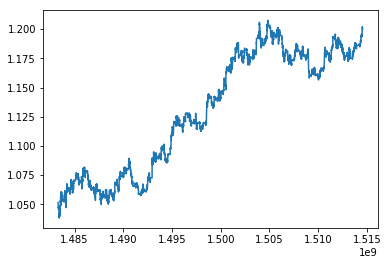

In [16]:
#A quick look at the dataframe time series using pyplot.plot(X_raw['EURUSD']):
plt.plot(X_raw['EURUSDclose'])

## Split data

In [17]:
# split into train and test sets

# Total samples
nsamples = n

# Splitting into train (70%) and test (30%) sets
split = 90 # training split% ; test (100-split)%
jindex = nsamples*split//100 # Index for slicing the samples

# Samples in train
nsamples_train = jindex

# Samples in test
nsamples_test = nsamples - nsamples_train
print("Total number of samples: ",nsamples,"\nSamples in train set: ", nsamples_train,
      "\nSamples in test set: ",nsamples_test)

# Here are train and test samples
X_train = X_raw.values[:jindex, :]
y_train = y_raw.values[:jindex]

X_test = X_raw.values[jindex:, :]
y_test = y_raw.values[jindex:]

print("X_train.shape = ", X_train.shape, "y_train.shape =", y_train.shape, "\nX_test.shape =  ",
      X_test.shape, "y_test.shape = ", y_test.shape)


Total number of samples:  8679 
Samples in train set:  7811 
Samples in test set:  868
X_train.shape =  (7811, 4) y_train.shape = (7811,) 
X_test.shape =   (868, 4) y_test.shape =  (868,)


In [18]:
#X_train as dataframe (optional, only for printing. See note in the beginning)
X_Train = pd.DataFrame(data=X_train)
X_Train.columns = X_raw.columns
print("X_train")
X_Train

X_train


,EURUSDopen,EURUSDhigh,EURUSDlow,EURUSDclose
0,1.05155,1.05213,1.05130,1.05150
1,1.05152,1.05175,1.04929,1.04929
2,1.04889,1.04904,1.04765,1.04868
3,1.04866,1.04885,1.04791,1.04803
4,1.04805,1.04812,1.04768,1.04782
5,1.04782,1.04782,1.04653,1.04659
6,1.04655,1.04680,1.04615,1.04668
7,1.04655,1.04747,1.04649,1.04747
8,1.04718,1.04729,1.04637,1.04699
9,1.04696,1.04771,1.04676,1.04686


In [19]:
#X_test as dataframe (optional, only for printing. See note in the beginning)
X_Test = pd.DataFrame(data=X_test)
X_Test.columns = X_raw.columns
print("X_test")
X_Test

X_test


,EURUSDopen,EURUSDhigh,EURUSDlow,EURUSDclose
0,1.18488,1.18531,1.18483,1.18488
1,1.18504,1.18514,1.18462,1.18514
2,1.18512,1.18527,1.18493,1.18502
3,1.18514,1.18514,1.18463,1.18490
4,1.18478,1.18507,1.18452,1.18496
5,1.18498,1.18527,1.18477,1.18503
6,1.18501,1.18544,1.18398,1.18427
7,1.18429,1.18495,1.18371,1.18476
8,1.18481,1.18555,1.18481,1.18534
9,1.18552,1.18552,1.18437,1.18479


## Transform features

**Note**

Becareful not to write `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a great difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, this is not always the case in Forex market data, as has been well stablished in literature. The correct way is to re-use parameters from the training set if we are doing any kind of transformation. So, the test set should basically stand for "new, unseen" data.


In [20]:
# Scale data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

y_train_std = sc.fit_transform(y_train.reshape(-1, 1))
y_test_std = sc.transform(y_test.reshape(-1, 1))

In [21]:
print("Mean:",sc.mean_)
print("Variance",sc.var_)

Mean: [1.12383816]
Variance [0.00252308]


In [22]:
#X_train_std as dataframe (optional, only for printing. See note in the beginning)
X_Train_std = pd.DataFrame(data=X_train_std)
X_Train_std.columns = X_Train.columns
print("X_train_std")
X_Train_std

X_train_std


,EURUSDopen,EURUSDhigh,EURUSDlow,EURUSDclose
0,-1.438023,-1.438023,-1.431822,-1.439736
1,-1.438620,-1.445583,-1.471819,-1.483732
2,-1.490953,-1.499494,-1.504453,-1.495876
3,-1.495530,-1.503274,-1.499280,-1.508816
4,-1.507668,-1.517796,-1.503856,-1.512996
5,-1.512245,-1.523764,-1.526740,-1.537483
6,-1.537517,-1.544055,-1.534302,-1.535691
7,-1.537517,-1.530727,-1.527536,-1.519964
8,-1.524980,-1.534307,-1.529924,-1.529519
9,-1.529358,-1.525952,-1.522163,-1.532107


In [23]:
#X_train_std as dataframe (optional, only for printing. See note in the beginning)
X_Test_std = pd.DataFrame(data=X_test_std)
X_Test_std.columns = X_Test.columns

print("X_test_std")
X_Test_std

X_test_std


,EURUSDopen,EURUSDhigh,EURUSDlow,EURUSDclose
0,1.215083,1.211381,1.225287,1.215534
1,1.218267,1.207999,1.221108,1.220710
2,1.219859,1.210585,1.227277,1.218321
3,1.220257,1.207999,1.221307,1.215932
4,1.213093,1.206606,1.219118,1.217127
5,1.217073,1.210585,1.224093,1.218520
6,1.217670,1.213967,1.208373,1.203390
7,1.203343,1.204219,1.203000,1.213145
8,1.213690,1.216155,1.224889,1.224692
9,1.227818,1.215558,1.216133,1.213742


In [24]:
#y_train as panda dataframe (optional, only for printing. See note in the beginning)
y_Train = pd.DataFrame(data=y_train)
y_Train.columns=["EURUSDclose"]
y_Train

,EURUSDclose
0,1.04929
1,1.04868
2,1.04803
3,1.04782
4,1.04659
5,1.04668
6,1.04747
7,1.04699
8,1.04686
9,1.04655


In [25]:
#y_train as panda dataframe (optional, only for printing. See note in the beginning)
y_Test = pd.DataFrame(data=y_test)
y_Test.columns=["EURUSDclose"]
y_Test

,EURUSDclose
0,1.18514
1,1.18502
2,1.18490
3,1.18496
4,1.18503
5,1.18427
6,1.18476
7,1.18534
8,1.18479
9,1.18526


In [26]:
#y_train_std as panda dataframe (optional, only for printing. See note in the beginning)
y_Train_std = pd.DataFrame(data=y_train_std)
y_Train_std.columns=["EURUSDclose"]
y_Train_std

,EURUSDclose
0,-1.484129
1,-1.496273
2,-1.509213
3,-1.513394
4,-1.537881
5,-1.536089
6,-1.520362
7,-1.529918
8,-1.532506
9,-1.538677


In [27]:
#y_train_std as panda dataframe (optional, only for printing. See note in the beginning)
y_Test_std = pd.DataFrame(data=y_train_std)
y_Test_std.columns=["EURUSDclose"]
y_Test_std

,EURUSDclose
0,-1.484129
1,-1.496273
2,-1.509213
3,-1.513394
4,-1.537881
5,-1.536089
6,-1.520362
7,-1.529918
8,-1.532506
9,-1.538677


## Implement the model

In [28]:
# Clears the default graph stack and resets the global default graph
ops.reset_default_graph()


In [29]:
# make results reproducible
seed = 2
tf.set_random_seed(seed)
np.random.seed(seed)  


# Parameters
learning_rate = 0.005
batch_size = 256
n_features = X_train.shape[1]#  Number of features in training data
epochs = 1000
display_step = 100
model_path = model_dir+"07_First_Forex_Prediction"
production_model_path = production_dir+"models/"+"07_First_Forex_Prediction"
n_classes = 1

# Network Parameters
# See figure of the model
d0 = D = n_features # Layer 0 (Input layer number of features)
d1 = 1024 # Layer 1 (1024 hidden nodes)
d2 = 512 # Layer 2 (512 hidden nodes) 
d3 = 256 # Layer 3 (256 hidden nodes)
d4 = 128 # Layer 4 (128 hidden nodes)
d5 = C = 1 # Layer 5 (Output layer)

# tf Graph input
print("Placeholders")
X = tf.placeholder(dtype=tf.float32, shape=[None, n_features], name="X")
y = tf.placeholder(dtype=tf.float32, shape=[None,n_classes], name="y")


# Initializers
print("Initializers")
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Create model
def multilayer_perceptron(X, variables):
    # Hidden layer with ReLU activation
    layer_1 = tf.nn.relu(tf.add(tf.matmul(X, variables['W1']), variables['bias1']), name="layer_1")
    # Hidden layer with ReLU activation
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, variables['W2']), variables['bias2']), name="layer_2")
    # Hidden layer with ReLU activation
    layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, variables['W3']), variables['bias3']), name="layer_3")
    # Hidden layer with ReLU activation
    layer_4 = tf.nn.relu(tf.add(tf.matmul(layer_3, variables['W4']), variables['bias4']), name="layer_4")
    # Output layer with ReLU activation
    out_layer = tf.nn.relu(tf.add(tf.matmul(layer_4, variables['W5']), variables['bias5']), name="out_layer")
    return out_layer

# Store layers weight & bias
variables = {
    'W1': tf.Variable(weight_initializer([n_features, d1]), name="W1"), # inputs -> d1 hidden neurons
    'bias1': tf.Variable(bias_initializer([d1]), name="bias1"), # one biases for each d1 hidden neurons
    'W2': tf.Variable(weight_initializer([d1, d2]), name="W2"), # d1 hidden inputs -> d2 hidden neurons
    'bias2': tf.Variable(bias_initializer([d2]), name="bias2"), # one biases for each d2 hidden neurons
    'W3': tf.Variable(weight_initializer([d2, d3]), name="W3"), ## d2 hidden inputs -> d3 hidden neurons
    'bias3': tf.Variable(bias_initializer([d3]), name="bias3"), # one biases for each d3 hidden neurons
    'W4': tf.Variable(weight_initializer([d3, d4]), name="W4"), ## d3 hidden inputs -> d4 hidden neurons
    'bias4': tf.Variable(bias_initializer([d4]), name="bias4"), # one biases for each d4 hidden neurons
    'W5': tf.Variable(weight_initializer([d4, d5]), name="W5"), # d4 hidden inputs -> 1 output
    'bias5': tf.Variable(bias_initializer([d5]), name="bias5") # 1 bias for the output
}

# Construct model
y_hat = multilayer_perceptron(X, variables)

# Cost function
print("Cost function")
mse = tf.reduce_mean(tf.squared_difference(y_hat, y))

# Optimizer
print("Optimizer")
optimizer = tf.train.AdamOptimizer().minimize(mse)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

def generate_one_epoch(X_train, y_train, batch_size):
    num_batches = int(len(X_train)) // batch_size
    if batch_size * num_batches < len(X_train):
        num_batches += 1

    batch_indices = range(num_batches)
    batch_n = np.random.permutation(batch_indices)
    for j in batch_n:
        batch_X = X_train[j * batch_size: (j + 1) * batch_size]
        batch_y = y_train[j * batch_size: (j + 1) * batch_size]

    yield batch_X, batch_y



Placeholders
Initializers
Cost function
Optimizer


## Train the model  and Evaluate the model

In [30]:
# Shape of tensors
print("X_train_std.shape = ", X_train_std.shape, "y_train.shape =", y_train.shape,
      "\nX_train_std.shape =  ", X_train_std.shape, "y_test.shape = ", y_test.shape)


X_train_std.shape =  (7811, 4) y_train.shape = (7811,) 
X_train_std.shape =   (7811, 4) y_test.shape =  (868,)


In [31]:
# Fit neural net
print("Fit neural net")

with tf.Session() as sess:

    # Writer to record image, scalar, histogram and graph for display in tensorboard
    writer = tf.summary.FileWriter("/tmp/tensorflow_logs", sess.graph)  # create writer
    writer.add_graph(sess.graph)

    # Run the initializer
    sess.run(init)
    
    # Restore model weights from previously saved model
    #Ram saver.restore(sess, model_path)
    #Ram print("Model restored from file: %s" % model_path)
    '''
    # Try to restore a model if any.
    try:
        saver.restore(sess, model_path)
        print("Model restored from file: %s" % model_path)
    except Exception:
        print("No model file to restore")
        pass
    '''
    # Training cycle
    mse_train = []
    mse_test = []

    
    # Run
    print("Run")
    printcounter = 0
    for e in range(epochs):
        # Minibatch training
        
        for batch_X, batch_y in generate_one_epoch(X_train_std, y_train, batch_size):
            # Run optimizer with batch
            sess.run(optimizer, feed_dict={X: batch_X, y: np.transpose([batch_y])})
            #Ram print("batch_X",batch_X)
            #Ram print("batch_y",batch_y)
         
        # Show progress
        if (printcounter == display_step):
            
            printcounter = 0
            print("Epoch: ", e)
            # MSE train and test
            mse_train.append(sess.run(mse, feed_dict={X: X_train_std, y: np.transpose([y_train])}))
            mse_test.append(sess.run(mse, feed_dict={X: X_test_std, y: np.transpose([y_test])}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
        
        printcounter += 1
        
    # Print final MSE after Training
    mse_final = sess.run(mse, feed_dict={X: X_test, y: np.transpose([y_test])})
    print(mse_final)
    
    # Close writer
    writer.flush()
    writer.close()
        
    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)
    print("First Optimization Finished!")


Fit neural net
Run
Epoch:  100
MSE Train:  0.0066263936
MSE Test:  0.014807874
Epoch:  200
MSE Train:  0.0012716963
MSE Test:  1.1004695e-05
Epoch:  300
MSE Train:  0.011530105
MSE Test:  0.02958147
Epoch:  400
MSE Train:  0.06092236
MSE Test:  0.10722729
Epoch:  500
MSE Train:  0.00049403677
MSE Test:  0.00016906655
Epoch:  600
MSE Train:  0.010172739
MSE Test:  4.9944865e-05
Epoch:  700
MSE Train:  0.00041126224
MSE Test:  0.000107200845
Epoch:  800
MSE Train:  0.0005514498
MSE Test:  1.6022494e-05
Epoch:  900
MSE Train:  0.00016947073
MSE Test:  0.00035529005
4.568873e-05
Model saved in file: ../models/07_First_Forex_Prediction
First Optimization Finished!


In [32]:
batch_y.shape

(256,)

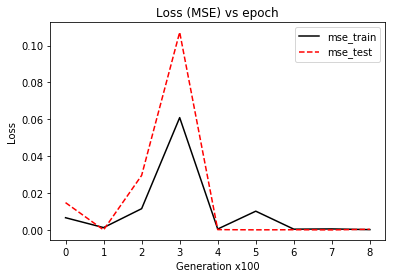

In [33]:
%matplotlib inline
# Plot loss (MSE) over time
plt.plot(mse_train, 'k-', label='mse_train')
plt.plot(mse_test, 'r--', label='mse_test')
plt.title('Loss (MSE) vs epoch')
plt.legend(loc='upper right')
plt.xlabel('Generation x'+str(display_step))
plt.ylabel('Loss')
plt.show()

### Tensorboard Graph


What follows is the graph we have executed and all data about it. Note the "save" label and the several layers.


![graph_4](../images/graph_4.png)


### Saving a Tensorflow model

So, now we have our model saved.

Tensorflow model has four main files:
* a) Meta graph:
This is a protocol buffer which saves the complete Tensorflow graph; i.e. all variables, operations, collections etc. This file has .meta extension.


* b) y c) Checkpoint files:
It is a binary file which contains all the values of the weights, biases, gradients and all the other variables saved. Tensorflow has changed from version 0.11. Instead of a single .ckpt file, we have now two files: .index and .data file that contains our training variables. 


* d) Along with this, Tensorflow also has a file named checkpoint which simply keeps a record of latest checkpoint files saved.


## Predict

Finally, we can use the model to make some predictions.

Starting prediction session...
INFO:tensorflow:Restoring parameters from ../models/07_First_Forex_Prediction
Model restored from file: ../models/07_First_Forex_Prediction
[[1.1836615]
 [1.1830435]
 [1.1836624]
 [1.1831424]
 [1.1830487]
 [1.1834234]
 [1.1823709]
 [1.1818514]
 [1.183465 ]
 [1.1826177]
 [1.1832442]
 [1.1836693]
 [1.182771 ]
 [1.1820136]
 [1.1825969]
 [1.1845007]
 [1.1849121]
 [1.1841197]
 [1.1840515]
 [1.185615 ]
 [1.188248 ]
 [1.191016 ]
 [1.1927453]
 [1.1915469]
 [1.1917328]
 [1.191921 ]
 [1.1920509]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.192567

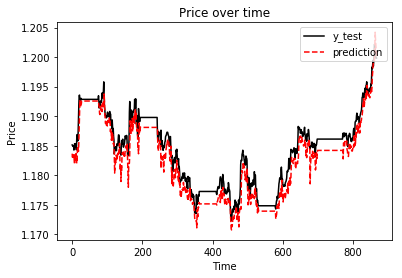

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/home/parrondo/PRODUCTION/models/07_First_Forex_Prediction/49/saved_model.pb'


In [34]:
# Running a new session for predictions and export model to production
print("Starting prediction session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Try to restore a model if any.
    try:
        saver.restore(sess, model_path)
        print("Model restored from file: %s" % model_path)
        # We try to predict the close price of test samples
        feed_dict = {X: X_test_std}
        
        prediction = sess.run(y_hat, feed_dict)
        print(prediction) 

        %matplotlib inline
        # Plot Prices over time
        plt.plot(y_test, 'k-', label='y_test')
        plt.plot(prediction, 'r--', label='prediction')
        plt.title('Price over time')
        plt.legend(loc='upper right')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()
        
        if to_production:
            # Pick out the model input and output
            X_tensor = sess.graph.get_tensor_by_name("X"+ ':0')
            y_tensor = sess.graph.get_tensor_by_name("out_layer" + ':0')

            model_input = build_tensor_info(X_tensor)
            model_output = build_tensor_info(y_tensor)
            
            # Create a signature definition for tfserving
            signature_definition = signature_def_utils.build_signature_def(
                inputs={"X": model_input},
                outputs={"out_layer": model_output},
                method_name=signature_constants.PREDICT_METHOD_NAME)

            model_version = 1
            export_model_dir = production_model_path+"/"+str(model_version)
            while os.path.exists(export_model_dir):
                model_version += 1
                export_model_dir = production_model_path+"/"+str(model_version)       
    
            builder = saved_model_builder.SavedModelBuilder(export_model_dir)  
            builder.add_meta_graph_and_variables(sess,
                                                 [tag_constants.SERVING],
                                                 signature_def_map={
                                                     signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                                                     signature_definition})

            # Save the model so we can serve it with a model server :)
            builder.save()

    except Exception:
        print("Unexpected error:", sys.exc_info()[0])
        pass



In [35]:
dfvisual = pd.DataFrame()
dfvisual["y_test"] = y_test
dfvisual["prediction"]= prediction
dfvisual["Abs.error"]=dfvisual["y_test"]-dfvisual["prediction"]
dfvisual["Relat.error"]=abs(dfvisual["Abs.error"]/dfvisual["y_test"])*100
dfvisual

,y_test,prediction,Abs.error,Relat.error
0,1.18514,1.183661,0.001479,0.124756
1,1.18502,1.183043,0.001977,0.166792
2,1.18490,1.183662,0.001238,0.104446
3,1.18496,1.183142,0.001818,0.153387
4,1.18503,1.183049,0.001981,0.167192
5,1.18427,1.183423,0.000847,0.071487
6,1.18476,1.182371,0.002389,0.201653
7,1.18534,1.181851,0.003489,0.294313
8,1.18479,1.183465,0.001325,0.111834
9,1.18526,1.182618,0.002642,0.222933


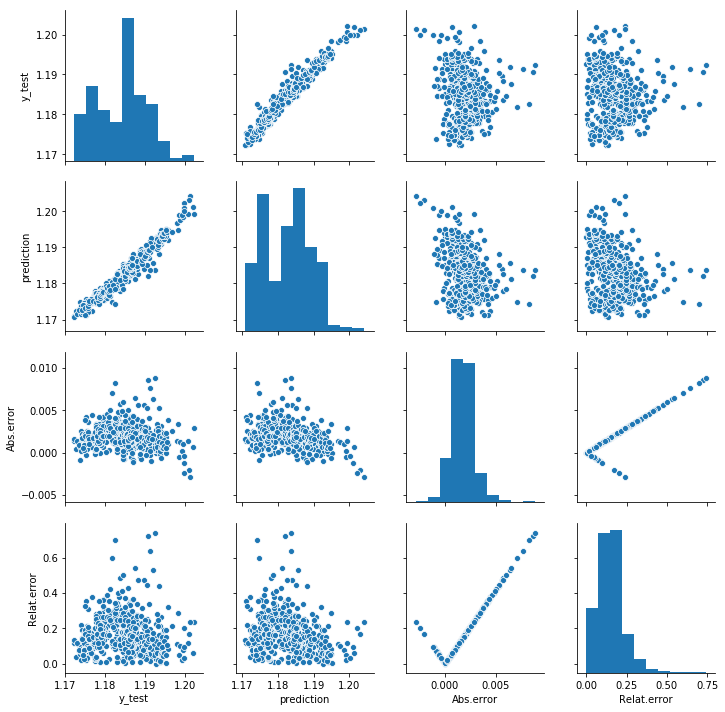

In [36]:
# Seaborn visualization library
import seaborn as sns

# Create the default pairplot
sns.pairplot(dfvisual)

OK, better results, but still not very good results. We could try to improve them with a deeper network (more layers) or retouching the net parameters and number of neurons. That is another story.

In [37]:
# Running a new session for predictions and export model to production
print("Starting prediction session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Try to restore a model if any.
    try:
        saver.restore(sess, model_path)
        print("Model restored from file: %s" % model_path)
        # We try to predict the close price of test samples
        X_test_pif = [[1.87374825, 1.87106024, 1.87083053, 1.86800846]]
        feed_dict = {X: X_test_pif}
        
        prediction = sess.run(y_hat, feed_dict)
        print(prediction)

    except Exception:
        print("Unexpected error:", sys.exc_info()[0])
        pass


Starting prediction session...
INFO:tensorflow:Restoring parameters from ../models/07_First_Forex_Prediction
Model restored from file: ../models/07_First_Forex_Prediction
[[1.2461773]]


In [38]:
X_test_std

array([[1.21508319, 1.21138084, 1.22528685, 1.21553408],
       [1.218267  , 1.20799896, 1.22110807, 1.22071004],
       [1.2198589 , 1.2105851 , 1.22727675, 1.21832114],
       ...,
       [1.5426173 , 1.53106792, 1.54128243, 1.53763841],
       [1.53425981, 1.52430416, 1.52277639, 1.51315211],
       [1.51157518, 1.51057771, 1.51262792, 1.51295304]])

Starting prediction session...
INFO:tensorflow:Restoring parameters from ../models/07_First_Forex_Prediction
Model restored from file: ../models/07_First_Forex_Prediction
[[1.1836615]
 [1.1830435]
 [1.1836624]
 [1.1831424]
 [1.1830487]
 [1.1834234]
 [1.1823709]
 [1.1818514]
 [1.183465 ]
 [1.1826177]
 [1.1832442]
 [1.1836693]
 [1.182771 ]
 [1.1820136]
 [1.1825969]
 [1.1845007]
 [1.1849121]
 [1.1841197]
 [1.1840515]
 [1.185615 ]
 [1.188248 ]
 [1.191016 ]
 [1.1927453]
 [1.1915469]
 [1.1917328]
 [1.191921 ]
 [1.1920509]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.1925673]
 [1.192567

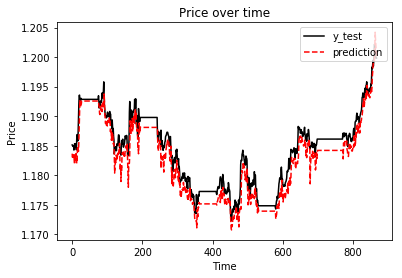

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/home/parrondo/PRODUCTION/models/07_First_Forex_Prediction/50/saved_model.pb'


In [39]:
# Running a new session for predictions and export model to production
print("Starting prediction session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    saver.restore(sess, model_path)
    print("Model restored from file: %s" % model_path)
    # We try to predict the close price of test samples
    feed_dict = {X: X_test_std}
    
    prediction = sess.run(y_hat, feed_dict)
    print(prediction) 

    %matplotlib inline
    # Plot Prices over time
    plt.plot(y_test, 'k-', label='y_test')
    plt.plot(prediction, 'r--', label='prediction')
    plt.title('Price over time')
    plt.legend(loc='upper right')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()
        

    # Pick out the model input and output
    X_tensor = sess.graph.get_tensor_by_name("X"+ ':0')
    y_tensor = sess.graph.get_tensor_by_name("out_layer" + ':0')

    model_input = build_tensor_info(X_tensor)
    model_output = build_tensor_info(y_tensor)
         
    # Create a signature definition for tfserving
    signature_definition = signature_def_utils.build_signature_def(
         inputs={"X": model_input},
         outputs={"out_layer": model_output},
         method_name=signature_constants.PREDICT_METHOD_NAME)
    
    model_version = 1
    export_model_dir = production_model_path+"/"+str(model_version)
    while os.path.exists(export_model_dir):
        model_version += 1
        export_model_dir = production_model_path+"/"+str(model_version)       
    
    builder = saved_model_builder.SavedModelBuilder(export_model_dir)
    builder.add_meta_graph_and_variables(sess,
                                         [tag_constants.SERVING],
                                         signature_def_map={
                                             signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                                             signature_definition})

    # Save the model so we can serve it with a model server :)
    builder.save()



In [40]:
len(y_train)

7811

In [41]:
X_Train_std

,EURUSDopen,EURUSDhigh,EURUSDlow,EURUSDclose
0,-1.438023,-1.438023,-1.431822,-1.439736
1,-1.438620,-1.445583,-1.471819,-1.483732
2,-1.490953,-1.499494,-1.504453,-1.495876
3,-1.495530,-1.503274,-1.499280,-1.508816
4,-1.507668,-1.517796,-1.503856,-1.512996
5,-1.512245,-1.523764,-1.526740,-1.537483
6,-1.537517,-1.544055,-1.534302,-1.535691
7,-1.537517,-1.530727,-1.527536,-1.519964
8,-1.524980,-1.534307,-1.529924,-1.529519
9,-1.529358,-1.525952,-1.522163,-1.532107


In [42]:
y_train.shape

(7811,)

In [43]:
# Mean relative error
dfvisual["Relat.error"].mean()

0.15334987531611016

In [44]:
# Mean Absoulte error
dfvisual["Abs.error"].mean()

0.0017724057803175793